# 평균모멘텀스코어 그림 2-25
- 투자 기간 :1986년 1월~2017년 6월
- 투자 대상 : 코스피지수, 이론현금
- 매수 규칙 :
  - 주식투자비율 = 코스피지수 최근 1~12개월 평균 모멘텀 스코어,
  - 현금비율 = 1 - 코스피지수 평균 모멘텀 스코어
- 매도 규칙 : 매달 말 주식의 평균 모멘텀 비중 업데이트하여 주식 : 현금 투자 비중을 리밸런싱(현금은 연 3% 수익률로 가정)
- 문제점 : 횡보장(2011.6~2016)
- 10.83%/-33.1%

In [6]:
from settings import *

## 월간 데이터를 사용


In [7]:
# 직접생성
# kospi = fdr.DataReader("KS11")['Close']
# df = pd.DataFrame()
# df['KOSPI'] = kospi.copy()
# df = df['1985-1':'2017-6'].resample('MS').first() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
# df['현금'] = pow(1.03, 1/12)
# df['현금'] = df['현금'].shift(1, fill_value=1.0)
# df['현금'] = df['현금'].cumprod()
# df

In [10]:
df = pd.read_csv('kospi_m.csv', index_col=0, parse_dates=True)
#-------------------------------------------
df['현금'] = pow(1.03, 1/12)
df['현금'] = df['현금'].shift(1, fill_value=1.0)
df['현금'] = df['현금'].cumprod()
#-------------------------------------------
df.head()

,KOSPI,현금
날짜,,
1985-01-04,1.000,1.000
1985-02-01,0.970,1.002
1985-03-02,0.982,1.005
1985-04-01,0.966,1.007
1985-05-01,0.965,1.010


<AxesSubplot:xlabel='날짜'>

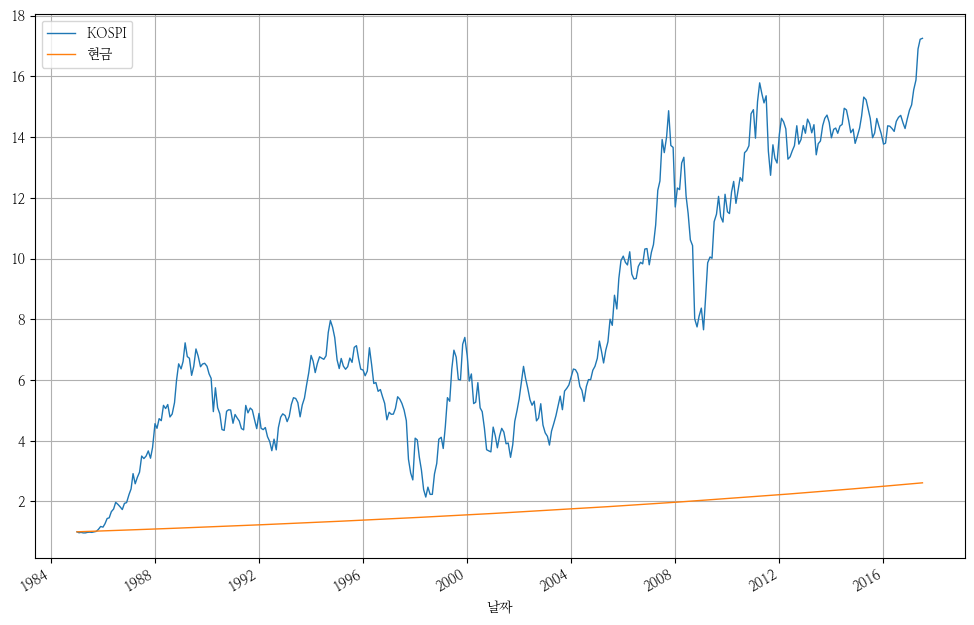

In [11]:
df.rebase(1).plot(figsize=(12,8))

In [12]:
data = df[:'2017-06'].copy()

In [13]:
bt_ew = long_only_ew(data, ['KOSPI', '현금'], "ew")

In [14]:
def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [15]:
score = 평균모멘텀스코어(data)

KOSPI 평균모멘텀스코어 만큼 할당하고 나머지는 현금 자산을 할당

In [17]:
weights = pd.DataFrame()
weights['KOSPI'] = score['KOSPI']
weights['현금']   = 1.0 - score['KOSPI']
weights.head(15) # 1986-1 이후 유효

,KOSPI,현금
날짜,,
1985-01-04,NaN,NaN
1985-02-01,NaN,NaN
1985-03-02,NaN,NaN
1985-04-01,NaN,NaN
1985-05-01,NaN,NaN
1985-06-01,NaN,NaN
1985-07-01,NaN,NaN
1985-08-01,NaN,NaN
1985-09-02,NaN,NaN


In [19]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_last_date=True),
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
            bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [20]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산
bt_ms = momentumscore(data, weights.dropna())#.shift(1))

In [21]:
bt_kospi = long_only_ew(data, ['KOSPI'], 'KOSPI')
bt_현금 = long_only_ew(data, ['현금'], '현금')

In [22]:
r_ms = bt.run(bt_ms)

1986-01-04 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.917
현금      0.083
Name: 1986-01-04 00:00:00, dtype: float64}
1986-02-01 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-02-01 00:00:00, dtype: float64}
1986-03-03 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-03-03 00:00:00, dtype: float64}
1986-04-01 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-04-01 00:00:00, dtype: float64}
1986-05-01 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-05-01 00:00:00, dtype: float64}
1986-06-02 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-06-02 00:00:00, dtype: float64}
1986-07-01 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-07-01 00:00:00, dtype: float64}
1986-08-01 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.917
현

In [23]:
r_ms.set_date_range('1986-1-4')
r_ms.display()

Stat                 MomScore
-------------------  ----------
Start                1986-01-04
End                  2017-06-01
Risk-free rate       0.00%

Total Return         2462.73%
Daily Sharpe         -
Daily Sortino        -
CAGR                 10.88%
Max Drawdown         -33.07%
Calmar Ratio         0.33

MTD                  1.89%
3m                   14.35%
6m                   17.68%
YTD                  17.68%
1Y                   18.75%
3Y (ann.)            5.13%
5Y (ann.)            2.66%
10Y (ann.)           3.77%
Since Incep. (ann.)  10.88%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.69
Monthly Sortino      1.56
Monthly Mean (ann.)  11.74%
Monthly Vol (ann.)   16.91%
Monthly Skew         1.10
Monthly Kurt         2.94
Best Month           21.59%
Worst Month          -11.48%

Yearly Sharpe        0.47
Yearly S

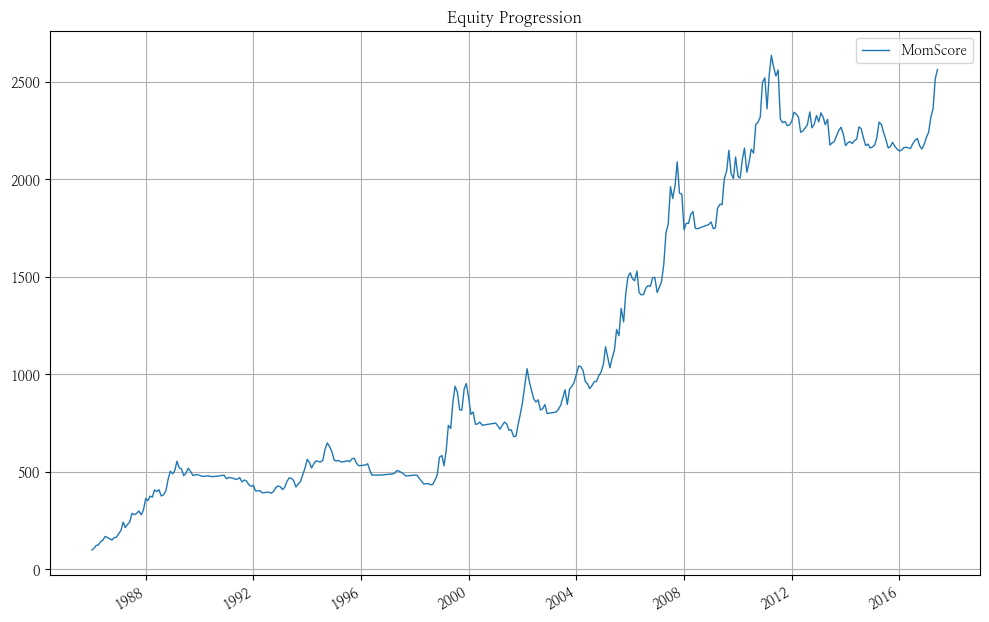

In [24]:
r_ms.plot(figsize=(12,8));

In [25]:
r_all = bt.run(bt_ms, bt_kospi, bt_ew)

1985-01-04 00:00:00
1985-01-04 00:00:00


In [26]:
r_all.set_date_range('1986-1-4')
r_all.display()

Stat                 MomScore    KOSPI       ew
-------------------  ----------  ----------  ----------
Start                1986-01-04  1986-01-04  1986-01-04
End                  2017-06-01  2017-06-01  2017-06-01
Risk-free rate       0.00%       0.00%       0.00%

Total Return         2462.73%    1390.95%    807.42%
Daily Sharpe         -           -           -
Daily Sortino        -           -           -
CAGR                 10.88%      8.98%       7.27%
Max Drawdown         -33.07%     -73.06%     -60.93%
Calmar Ratio         0.33        0.12        0.12

MTD                  1.89%       1.89%       1.67%
3m                   14.35%      14.35%      12.39%
6m                   17.68%      18.03%      15.55%
YTD                  17.68%      18.03%      15.55%
1Y                   18.75%      21.39%      18.60%
3Y (ann.)            5.13%       6.11%       5.68%
5Y (ann.)            2.66%       5.23%       4.92%
10Y (ann.)           3.77%       3.21%       3.18%
Since Incep. (ann.

<AxesSubplot:title={'center':'Equity Progression'}>

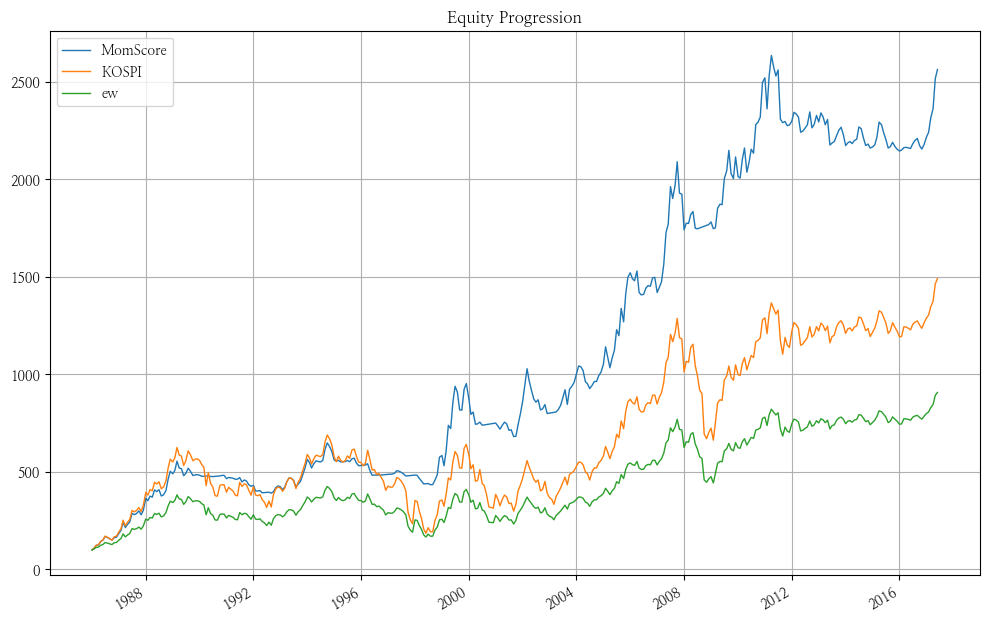

In [27]:
r_all.plot(figsize=(12,8))

In [28]:
r_현금 = bt.run(bt_현금)
r_kospi = bt.run(bt_kospi)


1985-01-04 00:00:00


## 그림 2.25

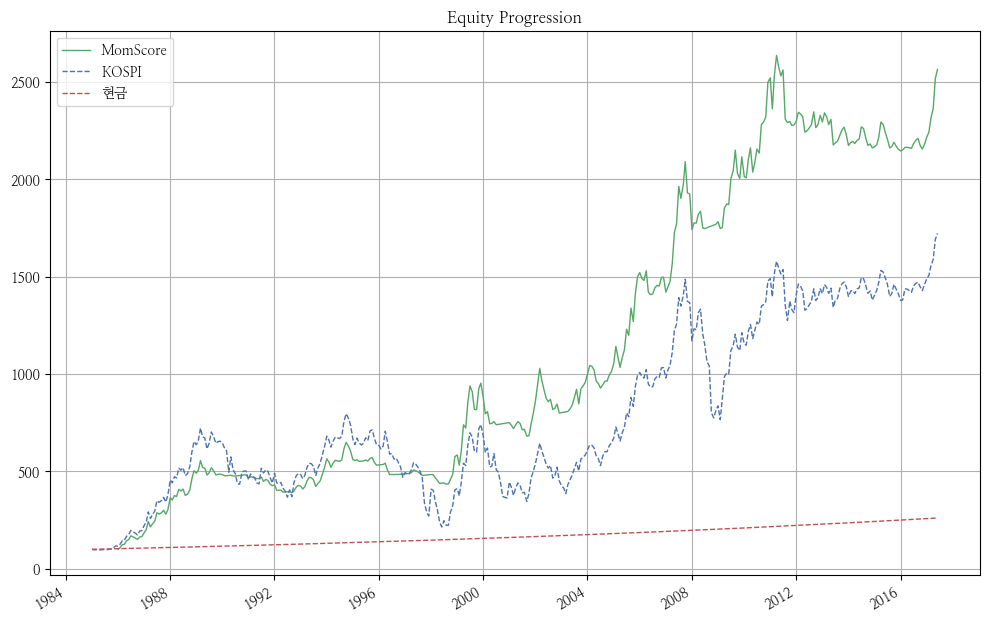

In [29]:
ax1 = r_ms.plot(color='g', figsize=(12,8));
r_kospi.plot(ax=ax1, ls='--', color='b', figsize=(12, 8));
r_현금.plot(ax=ax1, ls='--', color='r', figsize=(12, 8));

<AxesSubplot:>

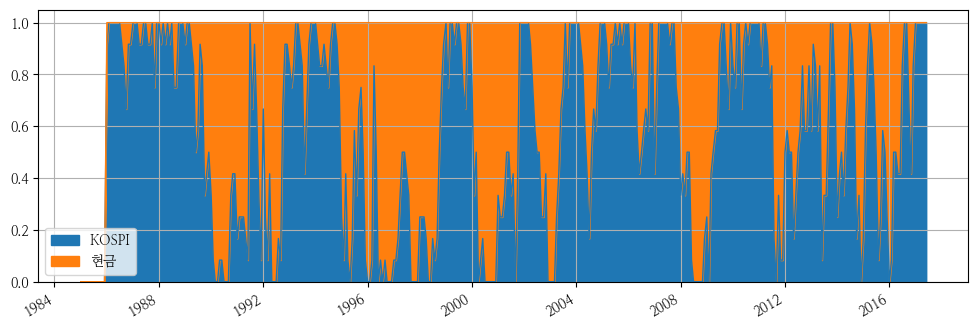

In [31]:
r_all.get_security_weights('MomScore').plot.area(figsize=(12,4))

In [32]:
r_ms.get_security_weights()['2016']

,KOSPI,현금
2016-01-04,0.000,1.000
2016-02-01,0.083,0.917
2016-03-02,0.500,0.500
2016-04-01,0.500,0.500
2016-05-02,0.417,0.583
2016-06-01,0.417,0.583
2016-07-01,0.833,0.167
2016-08-01,1.000,0.000
2016-09-01,1.000,0.000
2016-10-04,0.667,0.333


In [33]:
# qs.reports.full(r_all.prices['MomScore'].to_returns().dropna()['1986':],
#                 r_all.prices['KOSPI'].to_returns().dropna()['1986':])

부가적인 추가 검증 책이 안되었을때 excel가 비교했는데...
앞의 내용이 책과 거의 동일하다.
## 평균모멘텀스코어 검사 (코스피 모멘텀스코어)

https://docs.google.com/spreadsheets/d/1yC2bSZnTRBHVCZwFeHI_eH_-C9Y2amtu-CnbQy6f5mQ/edit?usp=sharing
와 비교해 보자.

**주의 사항**

1. 1986-1-31일부터 정상적으로 작동해야 한다. 즉 이 때가 기준이고 1이다.
    - bt.algos.RunAfterDate('1986-1-1')

In [34]:
kospi = fdr.DataReader("KS11")['Close']

data1 = pd.DataFrame()
data1['KOSPI'] = kospi.copy()
data1 = data1['1985-1':'2020-9'].resample('M').last() # 실제 말 마지막날이 공휴일이어도 마지막날 거래 한것과 같이 된다.
data1['현금'] = pow(1.03, 1/12)
data1['현금'] = data1['현금'].shift(1, fill_value=1.0)
data1['현금'] = data1['현금'].cumprod()
data1

,KOSPI,현금
Date,,
1985-01-31,138.900,1.000
1985-02-28,134.930,1.002
1985-03-31,136.460,1.005
1985-04-30,134.150,1.007
1985-05-31,134.090,1.010
...,...,...
2020-05-31,2029.600,2.842
2020-06-30,2108.330,2.849
2020-07-31,2249.370,2.856


In [35]:
score1 = 평균모멘텀스코어(data1)

In [36]:
weights1 = pd.DataFrame()
weights1['KOSPI'] = score1['KOSPI']
weights1['현금']   = 1.0 - score1['KOSPI']
weights1.head(20) # 1986-1 이후 유효

,KOSPI,현금
Date,,
1985-01-31,NaN,NaN
1985-02-28,NaN,NaN
1985-03-31,NaN,NaN
1985-04-30,NaN,NaN
1985-05-31,NaN,NaN
1985-06-30,NaN,NaN
1985-07-31,NaN,NaN
1985-08-31,NaN,NaN
1985-09-30,NaN,NaN


In [37]:
bt_KOSPI모멘텀스코어 = momentumscore(data1, weights1, "KOSPI모멘텀스코어", '1986-1-1')

In [38]:
bt_kospi1 = long_only_ew(data1, ['KOSPI'], 'KOSPI')

In [39]:
rt = bt.run(bt_KOSPI모멘텀스코어, bt_kospi1)

1986-01-31 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.917
현금      0.083
Name: 1986-01-31 00:00:00, dtype: float64}
1986-02-28 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-02-28 00:00:00, dtype: float64}
1986-03-31 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-03-31 00:00:00, dtype: float64}
1986-04-30 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-04-30 00:00:00, dtype: float64}
1986-05-31 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-05-31 00:00:00, dtype: float64}
1986-06-30 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-06-30 00:00:00, dtype: float64}
1986-07-31 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   1.000
현금      0.000
Name: 1986-07-31 00:00:00, dtype: float64}
1986-08-31 00:00:00 {'selected': ['KOSPI', '현금'], 'weights': KOSPI   0.917
현

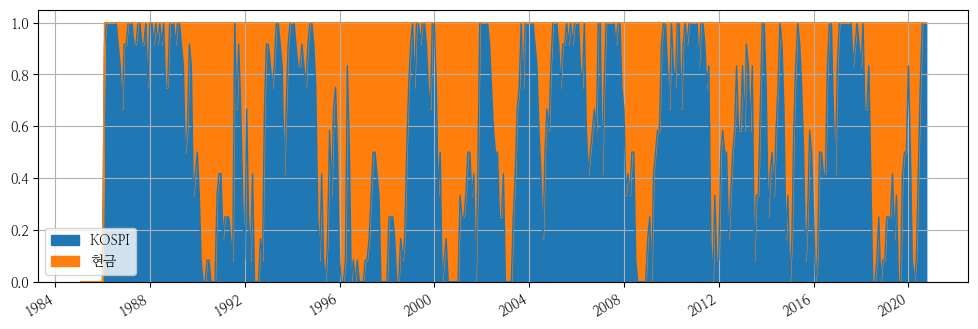

In [41]:
rt.get_security_weights('KOSPI모멘텀스코어').plot.area(figsize=(12,4));

In [42]:
rt.set_date_range('1986-1')
rt.display()

Stat                 KOSPI모멘텀스코어    KOSPI
-------------------  -------------------  ----------
Start                1986-01-31           1986-01-31
End                  2020-09-30           2020-09-30
Risk-free rate       0.00%                0.00%

Total Return         2519.67%             1351.12%
Daily Sharpe         -                    -
Daily Sortino        -                    -
CAGR                 9.88%                8.02%
Max Drawdown         -33.07%              -73.06%
Calmar Ratio         0.30                 0.11

MTD                  0.07%                0.07%
3m                   8.75%                10.41%
6m                   10.74%               17.16%
YTD                  4.27%                5.93%
1Y                   7.98%                12.84%
3Y (ann.)            0.75%                -0.94%
5Y (ann.)            3.86%                3.47%
10Y (ann.)           1.40%                2.20%
Since Incep. (ann.)  9.88%                8.02%

Daily Sharpe         -      

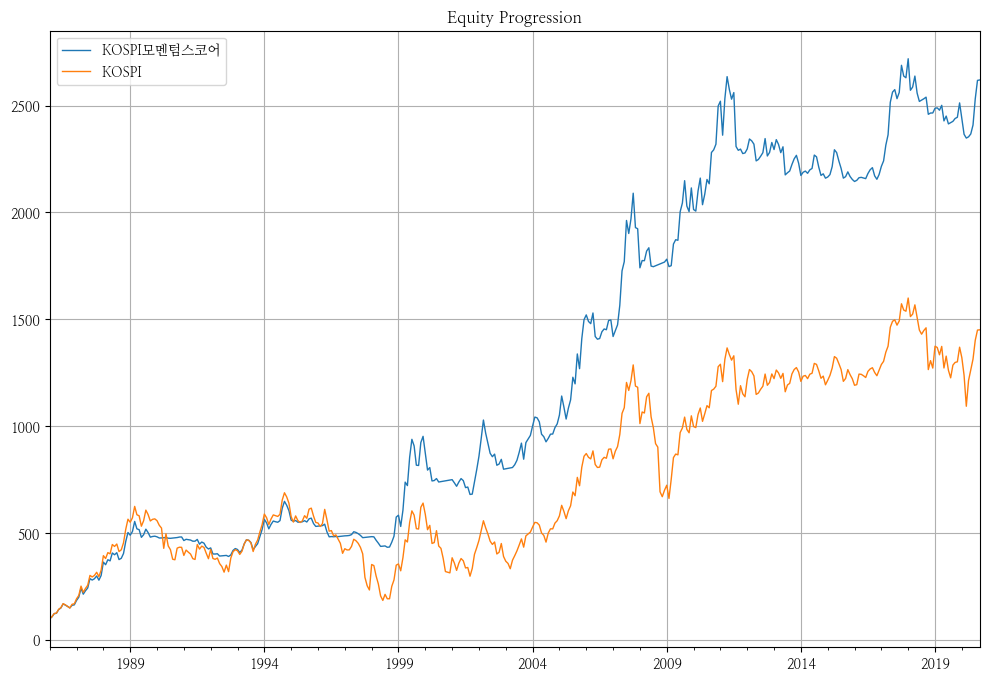

In [44]:
rt.plot(figsize=(12,8));

In [45]:
# qs.reports.full(rt.prices['KOSPI모멘텀스코어'].to_returns().dropna()['1986':],
#                 rt.prices['KOSPI'].to_returns().dropna()['1986':])

## 일간 데이터를 사용 (bt스타일)

In [46]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lags, months, cash):
        super(WeighAMS, self).__init__()
        self.lags = lags
        self.months = months
        self.cash = cash

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        # t0 = (target.now).strftime("%Y-%m")
        # start = (target.now -  pd.DateOffset(years=1)).strftime("%Y-%m")

        # print(selected, t0)
        print(f"\nprc : {target.now} {t0} ~ {start}")
        selected.remove(self.cash)
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        # weights = pd.Series(self.평균모멘텀스코어(prc, self.months), index=selected)
        weights = pd.Series(self.AMS(prc), index=selected)
        weights[self.cash] = 1 - weights.sum()
        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights
        print(f"{target.now} ", end =" ")
        for i, v in weights.items():
            print(f"{i}:{v:.3f}", end=" ")
        print("")
        return True

In [47]:
s12 = bt.Strategy('12개월',
    [
        bt.algos.RunMonthly(run_on_first_date=True,
                            run_on_end_of_period=False,
                            run_on_last_date=False),
        # bt.algos.PrintInfo('{name} : {now}'),
        bt.algos.SelectThese(['KOSPI', '현금']),
        WeighAMS(lags=0, months = 12, cash='현금'), # lags=0이면 위와 같다.
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
bt_s12 = bt.Backtest(s12, data, initial_capital=100000000)

In [48]:
r_12 = bt.run(bt_s12, bt_ms)


prc : 1985-01-04 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-01 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-02 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-01 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-01 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-01 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-01 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-01 00:00:00 1985-08 ~ 1984-08

prc : 1985-09-02 00:00:00 1985-09 ~ 1984-09

prc : 1985-10-02 00:00:00 1985-10 ~ 1984-10

prc : 1985-11-01 00:00:00 1985-11 ~ 1984-11

prc : 1985-12-02 00:00:00 1985-12 ~ 1984-12

prc : 1986-01-04 00:00:00 1986-01 ~ 1985-01
1986-01-04 00:00:00  KOSPI:0.917 현금:0.083 

prc : 1986-02-01 00:00:00 1986-02 ~ 1985-02
1986-02-01 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-03-03 00:00:00 1986-03 ~ 1985-03
1986-03-03 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-04-01 00:00:00 1986-04 ~ 1985-04
1986-04-01 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-05-01 00:00:00 1986-05 ~ 1985-05
1986-05-01 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-06-02 00

In [49]:
# 로직의 유효성 검증
r_12.set_date_range('1986-1-4')
r_12.display()

Stat                 12개월      MomScore
-------------------  ----------  ----------
Start                1986-01-04  1986-01-04
End                  2017-06-01  2017-06-01
Risk-free rate       0.00%       0.00%

Total Return         2462.73%    2462.73%
Daily Sharpe         -           -
Daily Sortino        -           -
CAGR                 10.88%      10.88%
Max Drawdown         -33.07%     -33.07%
Calmar Ratio         0.33        0.33

MTD                  1.89%       1.89%
3m                   14.35%      14.35%
6m                   17.68%      17.68%
YTD                  17.68%      17.68%
1Y                   18.75%      18.75%
3Y (ann.)            5.13%       5.13%
5Y (ann.)            2.66%       2.66%
10Y (ann.)           3.77%       3.77%
Since Incep. (ann.)  10.88%      10.88%

Daily Sharpe         -           -
Daily Sortino        -           -
Daily Mean (ann.)    -           -
Daily Vol (ann.)     -           -
Daily Skew           -           -
Daily Kurt           -  

In [50]:
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily['1985-1':'2020-9']

In [51]:
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range('1985', '2020-12-31', freq='D')
denominator = len(pd.date_range('1985', '2020-12-31', freq='D'))/len(pd.date_range('1985', '2020-12-31', freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()

In [52]:
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')
data_daily

,KOSPI,현금
Date,,
1985-01-04,139.530,1.000
1985-01-05,141.790,1.000
1985-01-07,145.510,1.000
1985-01-08,145.390,1.001
1985-01-09,143.260,1.001
...,...,...
2020-09-23,2333.240,2.875
2020-09-24,2272.700,2.875
2020-09-25,2278.790,2.875


In [53]:
bt_daily = bt.Backtest(s12, data_daily, name='12개월(일간)', initial_capital=100000000)

In [54]:
r_daily = bt.run(bt_daily)



prc : 1985-01-04 00:00:00 1985-01 ~ 1984-01

prc : 1985-02-01 00:00:00 1985-02 ~ 1984-02

prc : 1985-03-02 00:00:00 1985-03 ~ 1984-03

prc : 1985-04-01 00:00:00 1985-04 ~ 1984-04

prc : 1985-05-01 00:00:00 1985-05 ~ 1984-05

prc : 1985-06-01 00:00:00 1985-06 ~ 1984-06

prc : 1985-07-01 00:00:00 1985-07 ~ 1984-07

prc : 1985-08-01 00:00:00 1985-08 ~ 1984-08

prc : 1985-09-02 00:00:00 1985-09 ~ 1984-09

prc : 1985-10-02 00:00:00 1985-10 ~ 1984-10

prc : 1985-11-01 00:00:00 1985-11 ~ 1984-11

prc : 1985-12-02 00:00:00 1985-12 ~ 1984-12

prc : 1986-01-04 00:00:00 1986-01 ~ 1985-01
1986-01-04 00:00:00  KOSPI:0.917 현금:0.083 

prc : 1986-02-01 00:00:00 1986-02 ~ 1985-02
1986-02-01 00:00:00  KOSPI:0.917 현금:0.083 

prc : 1986-03-03 00:00:00 1986-03 ~ 1985-03
1986-03-03 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-04-01 00:00:00 1986-04 ~ 1985-04
1986-04-01 00:00:00  KOSPI:1.000 현금:0.000 

prc : 1986-05-01 00:00:00 1986-05 ~ 1985-05
1986-05-01 00:00:00  KOSPI:0.917 현금:0.083 

prc : 1986-06-02 00

In [55]:
r_daily.set_date_range('1986-1-4')
r_daily.display()

Stat                 12개월(일간)
-------------------  --------------
Start                1986-01-04
End                  2020-09-29
Risk-free rate       0.00%

Total Return         2522.39%
Daily Sharpe         0.69
Daily Sortino        1.11
CAGR                 9.86%
Max Drawdown         -35.16%
Calmar Ratio         0.28

MTD                  0.07%
3m                   9.21%
6m                   11.27%
YTD                  3.59%
1Y                   7.59%
3Y (ann.)            -0.43%
5Y (ann.)            3.11%
10Y (ann.)           0.71%
Since Incep. (ann.)  9.86%

Daily Sharpe         0.69
Daily Sortino        1.11
Daily Mean (ann.)    10.01%
Daily Vol (ann.)     14.44%
Daily Skew           -0.04
Daily Kurt           7.51
Best Day             7.01%
Worst Day            -7.34%

Monthly Sharpe       0.66
Monthly Sortino      1.51
Monthly Mean (ann.)  10.75%
Monthly Vol (ann.)   16.34%
Monthly Skew         1.18
Monthly Kurt         3.23
Best Month           21.08%
Worst Month          -10.9

In [56]:
r_daily.prices['1986-1-4':].to_drawdown_series().describe()

,12개월(일간)
count,9178.000
mean,-0.139
std,0.086
min,-0.352
25%,-0.202
50%,-0.143
75%,-0.067
max,0.000


In [57]:
r_all0 = bt.run(bt_daily, bt_ms)

In [58]:
# # XXX 결과가 다소 이상하다. daily/monthly가 섞이니.
r_all0.set_date_range('1986-1-4')
r_all0.display()


Stat                 12개월(일간)    MomScore
-------------------  --------------  ----------
Start                1986-01-04      1986-01-04
End                  2017-06-01      2017-06-01
Risk-free rate       0.00%           0.00%

Total Return         2514.12%        2462.73%
Daily Sharpe         -               -
Daily Sortino        -               -
CAGR                 10.95%          10.88%
Max Drawdown         -32.70%         -33.07%
Calmar Ratio         0.33            0.33

MTD                  5.63%           1.89%
3m                   12.70%          14.35%
6m                   16.41%          17.68%
YTD                  16.41%          17.68%
1Y                   16.06%          18.75%
3Y (ann.)            4.36%           5.13%
5Y (ann.)            2.26%           2.66%
10Y (ann.)           3.66%           3.77%
Since Incep. (ann.)  10.95%          10.88%

Daily Sharpe         -               -
Daily Sortino        -               -
Daily Mean (ann.)    -               -
Dail